In [1]:
import zipfile
from io import BytesIO

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

# Constants

RESOLUTION = 224
PATCH_SIZE = 16
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_dino_base16": "Probing_ViTs/vit_dino_base16.zip",
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}


In [2]:
# Data utilities

crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((224 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

def load_image_from_local(path, model_type):
    # Credit: Willi Gierke
#     response = requests.get(url)
    image = Image.open(path)
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image



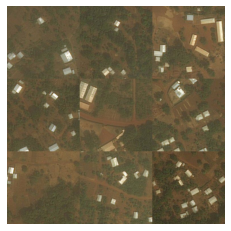

In [3]:
# Load a test image and display it
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

# img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
# image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

img_path = "merged_02.png"
image, preprocessed_image = load_image_from_local(img_path, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
# # Load a model
# download models
# zip_path = tf.keras.utils.get_file(
#     fname=FNAME,
#     origin=GITHUB_RELEASE,
# )

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall("./")

# os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> tf.keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs, training=False)

    return keras.Model(inputs, outputs=[outputs, attention_weights])


vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
# vit_base_dino_base16 = load_model(MODELS_ZIP["vit_dino_base16"])
print("Model loaded.")

Model loaded.


In [5]:
# Running regular inference with the model

predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)
print(attention_score_dict)

analog_clock
{'transformer_block_11_att': array([[[[9.9252095e-04, 9.6406460e-05, 4.2721935e-04, ...,
          2.1216043e-03, 9.7598974e-03, 2.1761126e-04],
         [1.9492332e-03, 2.1794860e-03, 4.2616897e-03, ...,
          3.7263928e-03, 1.6782150e-02, 2.7908806e-03],
         [9.0281432e-04, 2.8692109e-03, 1.5063322e-03, ...,
          4.6831355e-03, 3.5573144e-03, 3.0341097e-03],
         ...,
         [1.2768850e-03, 1.5046279e-03, 2.4470079e-03, ...,
          1.5614902e-03, 1.3199050e-02, 1.3608153e-03],
         [7.1193581e-03, 4.7750393e-04, 9.7097224e-04, ...,
          4.2383391e-03, 1.5290611e-02, 5.8041909e-04],
         [2.3205241e-03, 6.1070691e-03, 5.1492639e-03, ...,
          2.5057185e-03, 7.0849974e-03, 1.4656917e-03]],

        [[3.0416800e-04, 9.7506141e-05, 9.6058284e-05, ...,
          3.3686269e-04, 7.0986941e-02, 9.9449295e-05],
         [2.7645114e-03, 2.5734706e-03, 2.9454085e-03, ...,
          6.2163733e-03, 4.7989502e-03, 3.8746372e-03],
         [3.11

## Method I: Mean attention distance



In [6]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

Num Heads: 12.


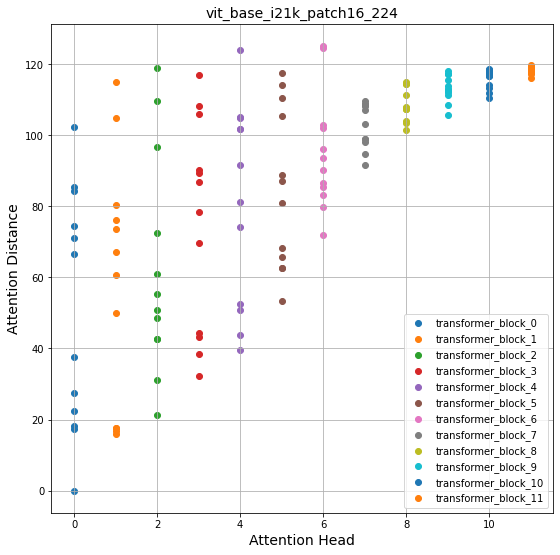

In [7]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

## Method II: Attention Rollout

In [8]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result

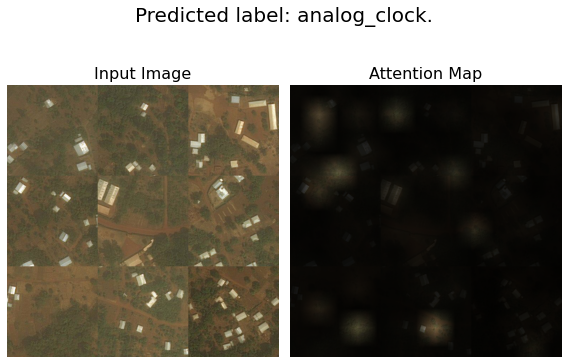

In [9]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

In [10]:
print(np.shape(attention_score_dict['transformer_block_11_att']))
print(np.shape(attn_rollout_result))

(1, 12, 197, 197)
(768, 768, 3)


## Method III: Attention heatmaps

In [11]:
# Load the model.
vit_dino_base16 = load_model(MODELS_ZIP["vit_dino_base16"])
print("Model loaded.")

# Preprocess the same image but with normlization.
# img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
# image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

img_path = "merged_02.png"
image, preprocessed_image = load_image_from_local(img_path, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

Model loaded.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


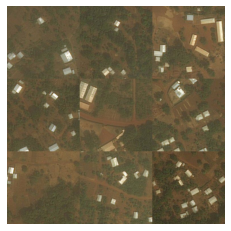

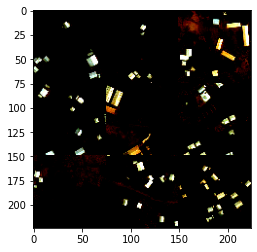

In [12]:
# print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.figure()
plt.imshow(preprocessed_image[0])
plt.show()

In [13]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

tf.Tensor(
[[0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 [0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 [0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 ...
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]], shape=(224, 224), dtype=float32)
tf.Tensor(
[[0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 [0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 [0.00213141 0.00213141 0.00213141 ... 0.00184422 0.00184422 0.00184422]
 ...
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]
 [0.00228791 0.00228791 0.00228791 ... 0.00537001 0.00537001 0.00537001]], shape=(224, 224), dtype=float32)
tf.Tensor(
[[0.0033939

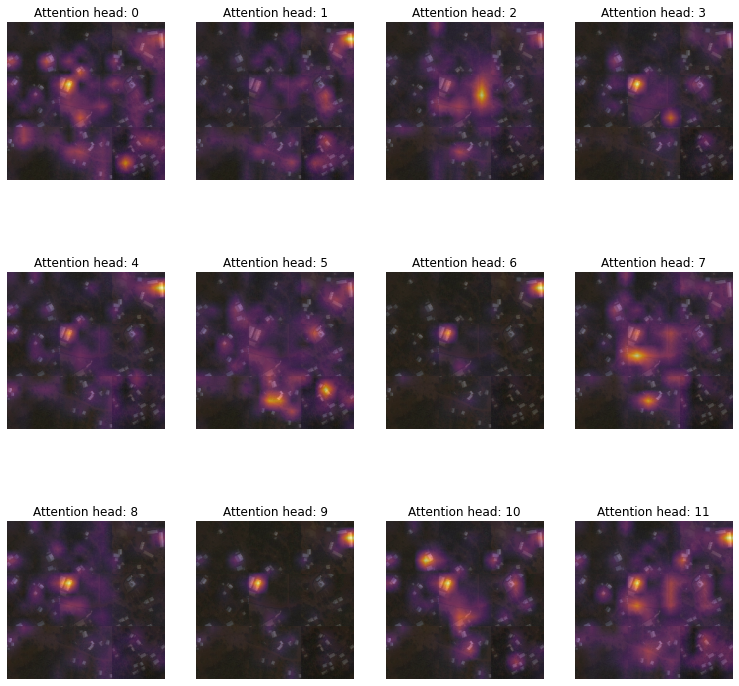

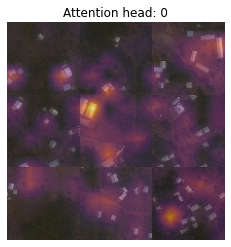

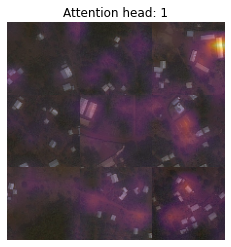

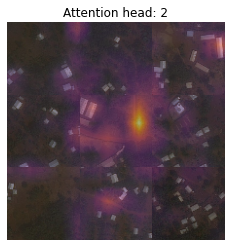

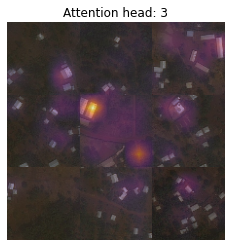

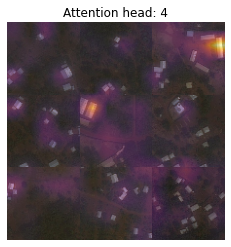

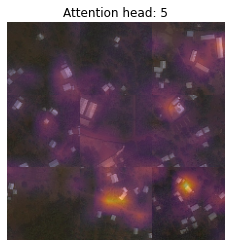

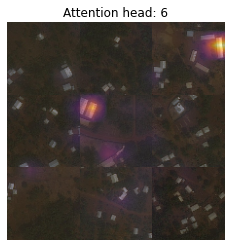

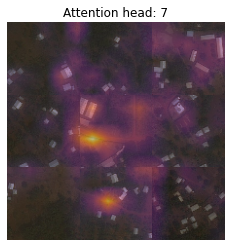

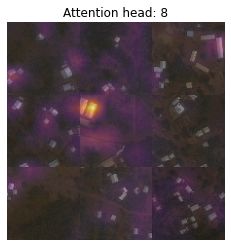

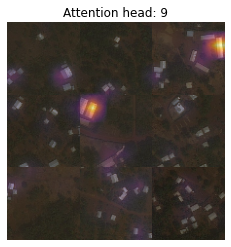

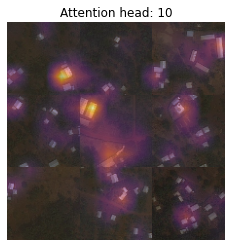

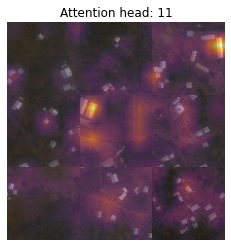

In [22]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)
# attentions = attention_heatmap(attn_scores, preprocessed_img_orig)


# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

sum_attentions = tf.constant(np.zeros([RESOLUTION, RESOLUTION], dtype='float32'))

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            print(attentions[..., img_count])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            print(attentions[..., img_count])
            sum_attentions = tf.add(sum_attentions, attentions[..., img_count])
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")          
            img_count += 1
            
for i in range(12):
    plt.figure()
    plt.imshow(preprocessed_img_orig[0])
    plt.imshow(attentions[..., i], cmap="inferno", alpha=0.5)
    plt.title(f"Attention head: {i}")
    plt.axis("off")
    plt.savefig(f"Attention_head_{i}.png")

sum tf.Tensor(
[[0.02698598 0.02698598 0.02698598 ... 0.028979   0.028979   0.028979  ]
 [0.02698598 0.02698598 0.02698598 ... 0.028979   0.028979   0.028979  ]
 [0.02698598 0.02698598 0.02698598 ... 0.028979   0.028979   0.028979  ]
 ...
 [0.01683014 0.01683014 0.01683014 ... 0.03453163 0.03453163 0.03453163]
 [0.01683014 0.01683014 0.01683014 ... 0.03453163 0.03453163 0.03453163]
 [0.01683014 0.01683014 0.01683014 ... 0.03453163 0.03453163 0.03453163]], shape=(224, 224), dtype=float32)
attention map [[0.00224883 0.00224883 0.00224883 ... 0.00241492 0.00241492 0.00241492]
 [0.00224883 0.00224883 0.00224883 ... 0.00241492 0.00241492 0.00241492]
 [0.00224883 0.00224883 0.00224883 ... 0.00241492 0.00241492 0.00241492]
 ...
 [0.00140251 0.00140251 0.00140251 ... 0.00287764 0.00287764 0.00287764]
 [0.00140251 0.00140251 0.00140251 ... 0.00287764 0.00287764 0.00287764]
 [0.00140251 0.00140251 0.00140251 ... 0.00287764 0.00287764 0.00287764]]
patch 0 0 (74, 74)
patch 0 1 (74, 74)
patch 0 2 (

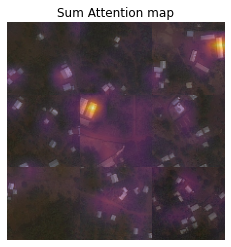

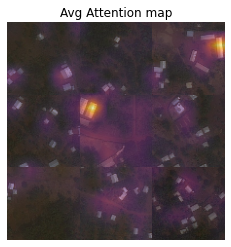

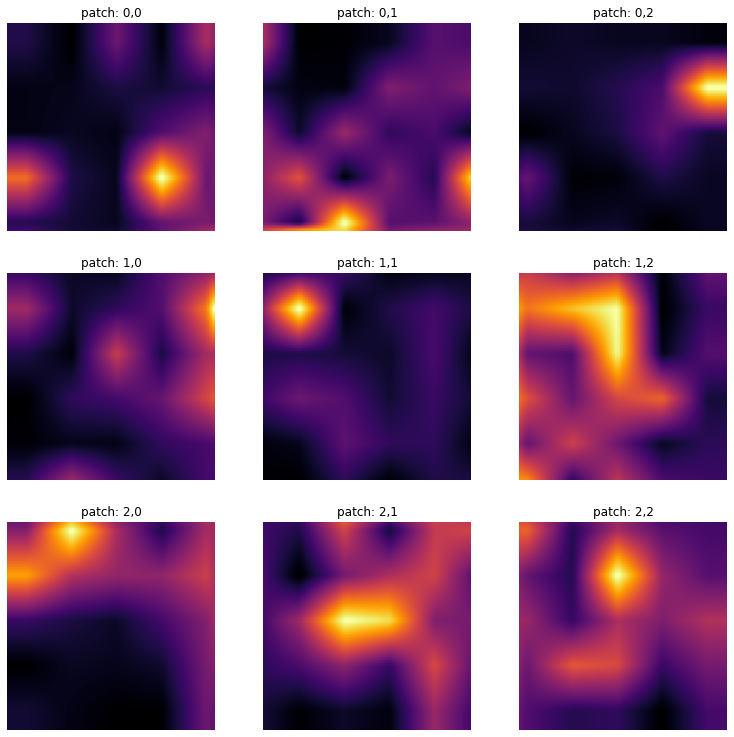

In [25]:

# print(preprocessed_img_orig)
# print(attentions)
avg_attention = sum_attentions/12
print("sum", sum_attentions)
    
plt.figure()
# print(np.shape(preprocessed_img_orig))
plt.imshow(preprocessed_img_orig[0])
plt.imshow(sum_attentions, cmap="inferno", alpha=0.5)
plt.title("Sum Attention map")
plt.axis("off")

plt.figure()
# print(np.shape(preprocessed_img_orig))
plt.imshow(preprocessed_img_orig[0])
plt.imshow(avg_attention, cmap="inferno", alpha=0.5)
plt.title("Avg Attention map")
plt.axis("off")
plt.savefig("attention_map.png")

attention_map = avg_attention.numpy()
print("attention map",attention_map)
attention_patches = []
attention_weights = []

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(3):
        attention_patch = attention_map[i*74+1:(i+1)*74+1, j*74+1:(j+1)*74+1]
        attention_patches.append(attention_patch)
        attention_weights.append(np.sum(attention_patch))
        print("patch",i,j,np.shape(attention_patch))
#         plt.figure()
        axes[i, j].imshow(attention_patch, cmap="inferno")
        axes[i, j].title.set_text(f"patch: {i},{j}")
        axes[i, j].axis("off")
        
        
print(np.shape(attention_patches))
print(attention_weights)

center_weight = attention_weights[4]
for i in range(len(attention_weights)):
    attention_weights[i] =  attention_weights[i]/center_weight
    
attention_weights.pop(4)
print(attention_weights)



# resized_img = tf.image.resize(preprocessed_img_orig[0], (768,768), method="bicubic")
# plt.imshow(resized_img)
# plt.figure()
plt.show()

# print(resized_img.shape)

## Method IV: Visualizing the learned projection filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


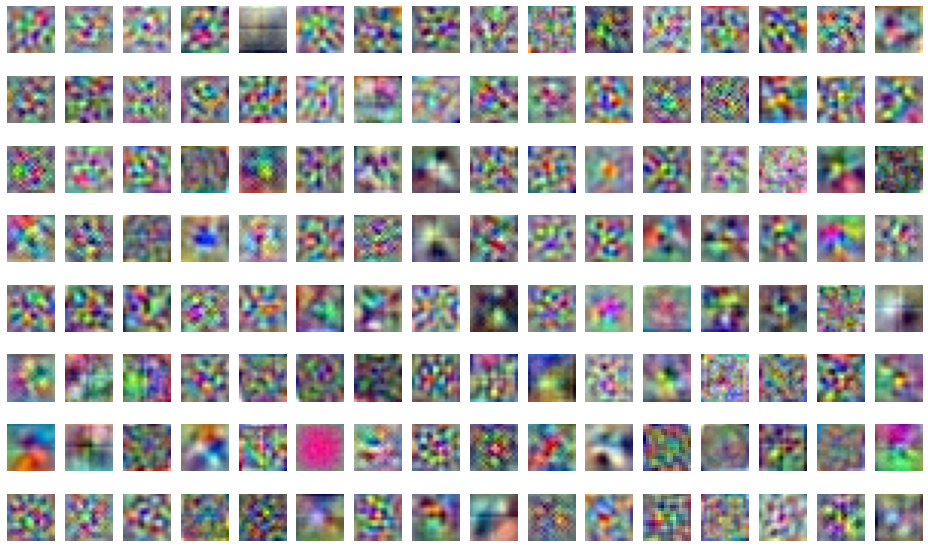

In [17]:
# Extract the projections.
projections = (
    vit_base_i21k_patch16_224.layers[1]
    .get_layer("projection")
    .get_layer("conv_projection")
    .kernel.numpy()
)
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]

# Scale the projections.
scaled_projections = MinMaxScaler().fit_transform(
    projections.reshape(-1, projection_dim)
)

# Reshape the scaled projections so that the leading
# three dimensions resemble an image.
scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)

# Visualize the first 128 filters of the learned
# projections.
fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()

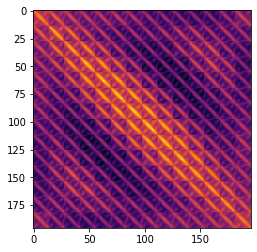

In [18]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()